In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import datetime
import glob
from pathlib import Path
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

DOWNLOAD_DIR = 'C:/Users/Aleks/lecture-scientific-computing/entsoe-data'

This will import the data, you have to run it to be able to solve the homework.

In [3]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(DOWNLOAD_DIR)

Concatenating 68 csv files...
Loading done.


# Exercise 1 - Calculate the relation of Wednesday average consumption to Sunday average consumption for selected countries

In this exercise, calculate the relation of Wednesday average consumption to Sunday average consumption for the following countries: Austria, Germany, United Kingdom, Spain, Sweden, Italy, Croatia.

(1) First create a variable that contains only power consumption data for these countries. The pandas command ```isin()``` may be very helpful here. Reduce the data to only consider the period 2015-01-01 until 2019-12-31. The lecture slides may contain relevant code here.

(2) Then, group the data by weekday and country (i.e. AreaName). Use ```groupby``` and ```mean```for that purpose. 

(3) Calculate for all countries the proportion of Wednesday (day 2) and Sunday (day 6) by dividing the two values.

(4) For which country, this relative value is highest? What could this indicate?

In [9]:
power_demand.columns

Index(['Year', 'Month', 'Day', 'ResolutionCode', 'areacode', 'AreaTypeCode',
       'AreaName', 'MapCode', 'TotalLoadValue', 'UpdateTime'],
      dtype='object')

In [156]:
# use isin to filter countries & time

filter1 = power_demand['AreaName'].isin(['Austria','Germany','United Kingdom','Spain','Sweden','Italy','Croatia'])
filter2 = power_demand['Year'].isin([2015,2016,2017,2018,2019])
power_demand_selected = power_demand[filter1 & filter2]

,Year,Month,Day,ResolutionCode,areacode,AreaTypeCode,AreaName,MapCode,TotalLoadValue,UpdateTime
DateTime,,,,,,,,,,
2015-01-01 00:00:00,2015,1,1,PT15M,10YAT-APG------L,CTY,Austria,AT,6017.2,2017-09-14 04:00:15
2015-01-01 00:15:00,2015,1,1,PT15M,10YAT-APG------L,CTY,Austria,AT,5966.8,2017-09-14 04:00:15
2015-01-01 00:30:00,2015,1,1,PT15M,10YAT-APG------L,CTY,Austria,AT,5935.6,2017-09-14 04:00:15
2015-01-01 00:45:00,2015,1,1,PT15M,10YAT-APG------L,CTY,Austria,AT,5934.4,2017-09-14 04:00:15
2015-01-01 01:00:00,2015,1,1,PT15M,10YAT-APG------L,CTY,Austria,AT,5750.8,2017-09-14 04:00:15
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 21:30:00,2019,12,31,PT30M,GB,CTY,United Kingdom,GB,34772.0,2020-01-06 22:16:17
2019-12-31 22:00:00,2019,12,31,PT30M,GB,CTY,United Kingdom,GB,32305.0,2020-01-06 22:16:17
2019-12-31 22:30:00,2019,12,31,PT30M,GB,CTY,United Kingdom,GB,31521.0,2020-01-06 22:16:17


In [67]:
power_demand_selected_country = power_demand_selected.groupby([power_demand_selected.index.weekday,
                                                               "AreaName"]).mean()
# power_demand_selected_country

In [77]:
power_demand_wed = power_demand_selected_country.loc[2,['TotalLoadValue']]
power_demand_sun = power_demand_selected_country.loc[6,['TotalLoadValue']]

power_demand_ratio = power_demand_wed / power_demand_sun
power_demand_ratio

power_demand_ratio[power_demand_ratio['TotalLoadValue'] == power_demand_ratio['TotalLoadValue'].max()]
# Italy
# maybe the share of companies vs. household energy consumption is relatively high -> many companies 
# do not operate on the weekends and househoulds do not consume that much energy, due relatively 
# warm seasons, if we would compare sun vs wed in summer vs in winter; could help


,TotalLoadValue
AreaName,
Italy,1.376237


# Exercise 2 - Calculate the monthly average consumption as deviation from mean consumption

For the same countries as in the above dataset, calculate the monthly mean consumption as deviation from the mean of consumption over the whole time. Plot the curves for all countries.

(1) First create a variable that contains only power consumption data for the selected countries. The pandas command ```isin()``` may be very helpful here. If you did Exercise 1, you can use the same dataset.

(2) Then, aggregate the data by country (i.e. AreaName) and month. Use ```groupby``` and ```mean``` for that purpose. Select the column ```TotalLoadValue``` from the result.

(3)  Aggregate the data by country (i..e AreaName) only, i.e. calculate the average consumption by country using ```groupby``` and ```mean```. Select the column ```TotalLoadValue``` from the result.

(4) Divide the result of (2) by (3) and observe how well broadcasting works here.

(5) Use the command ```unstack``` on the result. How does the table look now? Plot the result. If your resulting, unstacked dataframe is called ```result```, you may use ```result.plot()``` to get a nice plot.

(6) How would you explain the difference in the curve between Croatia and Sweden?


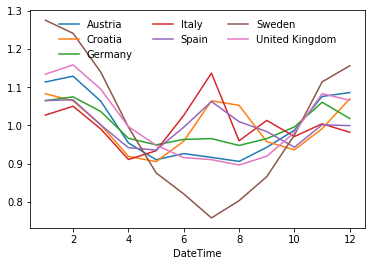

In [102]:
power_demand_month = power_demand_selected.groupby([power_demand_selected.index.month, "AreaName"]).mean()
power_demand_month = power_demand_month['TotalLoadValue']

power_demand_average = power_demand_selected.groupby('AreaName').mean()
power_demand_average = power_demand_average['TotalLoadValue']

power_demand_month_average = power_demand_month / power_demand_average
power_demand_month_average

power_demand_unstacked = power_demand_month_average.unstack()
power_demand_unstacked

power_demand_unstacked.plot()
plt.legend(loc = 'upper center', frameon=False, ncol=3)
plt.show()

# the graph shows for sweden that it has the highest consumption in winter months and
# the lowest in summer of all countries 
# this could partially be due to the fact that sweden has the biggest gap between sunlight per day
# (very long days in summer, exteremly short in winter)
# croatia on the other might have this spike of consumption in july & august due to the
# many tourists visiting the country in this time period

# Exercise 3 - calculate the hourly average consumption as deviation from mean consumption

Do the same as in exercise 2, but now for the hourly average consumption. I.e. how much is consumed on each of the 24 hours of a day?

Which country has the lowest, which the highest variability? What may be the reason for it?

AreaName
Austria           0.131277
Croatia           0.155485
Germany           0.127966
Italy             0.163838
Spain             0.118720
Sweden            0.092709
United Kingdom    0.177526
dtype: float64

Country with the highest standard deviation
 AreaName
United Kingdom    0.177526
dtype: float64

Country with the lowest standard deviation
 AreaName
Sweden    0.092709
dtype: float64


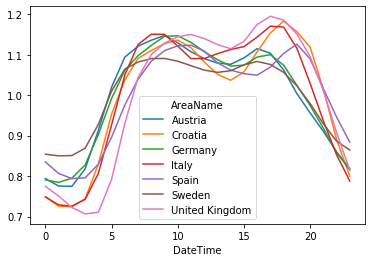

In [150]:
power_demand_hour = power_demand_selected.groupby([power_demand_selected.index.hour, "AreaName"]).mean()
power_demand_hour = power_demand_hour['TotalLoadValue']

power_demand_hour_average = power_demand_hour / power_demand_average

power_demand_hour_unstacked = power_demand_hour_average.unstack()

std_country = power_demand_hour_unstacked.std()
print(std_country)
print('\nCountry with the highest standard deviation\n',std_country[std_country == std_country.max()])
print('\nCountry with the lowest standard deviation\n',std_country[std_country == std_country.min()])

# looking at the descriptive statistics reveals that the highest disparity of energy consumption
# in regards to hours, can be observed for the uk (standard deviation = 0.178), and the lowest
# for sweden (0.092)
# i suspect a smiliar reason as mentioned before, sweden --> hours of sunshine
# in the case of the uk, mild winters do not require much heating at home, but during operating hours
# companies do need a lot of energy, idk?
power_demand_hour_unstacked.plot()
plt.show()



# Exercise 4 - Calculate the average load per capita

Below you find a table with population data for our selected countries. You should use it to calculate per capita consumption.

(1) Calculate the average load in all countries using ```groupby``` and ```mean``` and select the column ```TotalLoadValue``` from the result.

(2) Divide the result by the ```Population``` column of the dataframe ```population```. Observe, how broadcasting helps here nicely.

(3) Plot the result. Which country has the highest load, which the lowest? What may be the reason? In which unit is this value? How could we convert it to MWh per year?

In [138]:
population = pd.DataFrame({'AreaName': ["Austria", "Croatia", "Germany", "Italy", "Spain", "Sweden", "United Kingdom"],
             'Population': [8840521, 4087843, 82905782, 60421760, 46796540, 10175214, 66460344]})

population.index = population["AreaName"]

population

,AreaName,Population
AreaName,,
Austria,Austria,8840521
Croatia,Croatia,4087843
Germany,Germany,82905782
Italy,Italy,60421760
Spain,Spain,46796540
Sweden,Sweden,10175214
United Kingdom,United Kingdom,66460344


In [157]:
power_demand_last = power_demand_selected.groupby( "AreaName").mean()
power_demand_last = power_demand_last['TotalLoadValue']

power_demand_per_capita = power_demand_last / population['Population']
print(power_demand_per_capita)

print('\nCountry with the highest per capita consumption\n',
      power_demand_per_capita[power_demand_per_capita == power_demand_per_capita.max()])
print('\nCountry with the lowest per capita consumption\n',
      power_demand_per_capita[power_demand_per_capita == power_demand_per_capita.min()])

# sweden high consumption due to really cold overall temp. & high economic activity 
# croatia warm weather & not so energy intensive economic activity

# TotalLoadValue in Megawatt --> 1 MW * 365 * 24 = 1 MWh


AreaName
Austria           0.000806
Croatia           0.000490
Germany           0.000674
Italy             0.000549
Spain             0.000613
Sweden            0.001535
United Kingdom    0.000546
dtype: float64

Country with the highest per capita consumption
 AreaName
Sweden    0.001535
dtype: float64

Country with the lowest per capita consumption
 AreaName
Croatia    0.00049
dtype: float64
